### HyperFace: A Deep Multi-task Learning Framework for Face Detection, Landmark Localization, Pose Estimation, and Gender Recognition

https://arxiv.org/pdf/1603.01249.pdf

- CNN architecture for face detection, landmark localization, pose estimation and gender classification simultaneously (boosting the performance of individual tasks [58] , [57], [5]). The network architecture is deep in both vertical and horizontal direction. Based on Alexnet.
- Post-processing methods: iterative region proposals and landmarks-based non-maximum suppression
- overall time taken to perform all the four tasks was 3s per image
- face related tasks benefit from using the multitask learning framework.
- **Lower layers respond to edges and corners, and hence contain better localization properties. They are more suitable for learning landmark localization and pose estimation tasks.** Higher layers are class-specific and suitable for learning complex tasks such as face detection and gender recognition (detection and classification) [53]. We refer the set of intermediate layer features as hyperfeatures. [1]
- Since the adjacent layers are highly correlated, we do not consider all the intermediate layers for fusion.
- Features fusion aims to transform the features to a common subspace where they can be combined linearly or non-linearly: fusion-CNN to fuse the hyperfeatures
- We did not include any pooling operation in the fusion network as it provides local invariance which is not desired for the face landmark localization task.
- HyperFace consists of three modules.
    - The first one generates class independent region-proposals from the given image and scales them to 227 × 227 pixels.
    - The second module is a CNN which takes in the resized candidate regions and classifies them as face or non-face. If a region gets classified as a face, the network additionally provides facial landmarks locations, estimated head pose and gender information.
    - The third module is a post-processing step which involves iterative region propos- als and landmarks-based non-maximum suppression (NMS) to boost the face detection score and improve the perfor- mance of individual tasks.
- Datasets
    - Annotated Face in-the-Wild (AFW) [57] for evaluating face detection, landmark localization, and pose estima- tion tasks
    - Annotated Facial Landmarks in the Wild (AFLW) [22] for evaluating landmark localization and pose estima- tion tasks
    - Face Detection Dataset and Benchmark (FDDB) [18] and PASCAL faces [48] for evaluating the face detection results
    - Large-scale CelebFaces Attributes (CelebA) [31] and LFWA [17] for evaluating gender recognition results.
- Selective Search [43] algorithm in RCNN [12]

#### Using HyperFace trained model

1. Using _Ubuntu16.04_ with nvidia-docker and cuda8/cudnn5

- Clone the repo: https://github.com/takiyu/hyperface
    
- I built a Dockerfile, use it to build the image:
    - `sudo docker build -t hyperface .`
    
- Start the image:
    - `sudo nvidia-docker run -it --rm -p 8888-9000:8888-9000 -v /home/lmiguel/Projects:/Projects --name hyperface hyperface /bin/bash`

In [16]:
import chainer
import cv2
import numpy as np
import config
import drawing
import models


def _cvt_variable(v):
    # Convert from chainer variable
    if isinstance(v, chainer.variable.Variable):
        v = v.data
        if hasattr(v, 'get'):
            v = v.get()
    return v

In [17]:
class Args:
    model = '/Projects/hyperface/hyperface/model/model_epoch_190'
    img = '/Projects/datasets/aflw/aflw/data/flickr/0/image00288.jpg'
    config = '/Projects/hyperface/hyperface/config.json'

args = Args() 
    
print('Define a HyperFace model')
model = models.HyperFaceModel()
model.train = False
model.report = False
model.backward = False

config.load(args.config)

# Initialize model
print('Initialize a model using model "{}"'.format(args.model))
chainer.serializers.load_npz(args.model, model)

# Setup GPU
if config.gpu >= 0:
    print("using GPU")
    chainer.cuda.check_cuda_available()
    chainer.cuda.get_device(config.gpu).use()
    model.to_gpu()
    xp = chainer.cuda.cupy
else:
    print("using CPU")
    xp = np

Define a HyperFace model
Initialize a model using model "/Projects/hyperface/hyperface/model/model_epoch_190"
using CPU


In [21]:
def use_network_on_image(model, path):
    
    # Load image file
    print('Load an image from "{}"'.format(path))
    img = cv2.imread(path)
    if img is None:
        print('Failed to load')
        return None
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load image file
    img = img.astype(np.float32) / 255.0  # [0:1]
    img = cv2.resize(img, models.IMG_SIZE)
    img = cv2.normalize(img, None, -0.5, 0.5, cv2.NORM_MINMAX)
    img = np.transpose(img, (2, 0, 1))

    # Create single batch
    imgs = xp.asarray([img])
    x = chainer.Variable(imgs, volatile=True)

    # Forward
    print('Forward the network')
    y = model(x)

    # Chainer.Variable -> np.ndarray
    imgs = _cvt_variable(y['img'])
    detections = _cvt_variable(y['detection'])
    landmarks = _cvt_variable(y['landmark'])
    visibilitys = _cvt_variable(y['visibility'])
    poses = _cvt_variable(y['pose'])
    genders = _cvt_variable(y['gender'])

    # Use first data in one batch
    img = imgs[0]
    detection = detections[0]
    landmark = landmarks[0]
    visibility = visibilitys[0]
    pose = poses[0]
    gender = genders[0]

    img = np.transpose(img, (1, 2, 0))
    img = img.copy()
    img += 0.5  # [-0.5:0.5] -> [0:1]
    detection = (detection > 0.5)
    gender = (gender > 0.5)
    
    return img, detection, landmark, visibility, poses, genders


Load an image from "/Projects/datasets/aflw/aflw/data/flickr/0/image00288.jpg"
Forward the network


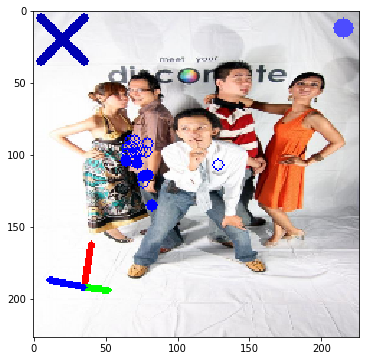

In [22]:
img, detection, landmark, visibility, poses, genders = use_network_on_image(model, args.img)

# Draw results
drawing.draw_detection(img, detection)
landmark_color = (0, 1, 0) if detection == 1 else (0, 0, 1)
drawing.draw_landmark(img, landmark, visibility, landmark_color, 0.5)
drawing.draw_pose(img, pose)
drawing.draw_gender(img, gender)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(6, 6))
plt.imshow(img)

Load an image from "/Projects/datasets/aflw/aflw/data/flickr/0/image00512.jpg"
Forward the network


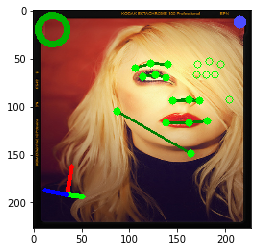

In [24]:
args.img = '/Projects/datasets/aflw/aflw/data/flickr/0/image00512.jpg'
img, detection, landmark, visibility, poses, genders = use_network_on_image(model, args.img)

# Draw results
drawing.draw_detection(img, detection)
landmark_color = (0, 1, 0) if detection == 1 else (0, 0, 1)
drawing.draw_landmark(img, landmark, visibility, landmark_color, 0.5)
drawing.draw_pose(img, pose)
drawing.draw_gender(img, gender)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.imshow(img)